In [2]:
%%writefile /kaggle/working/RWKV-TS/configs/train_config.yaml

data:
  path: "/kaggle/working/BNB_OHLC_5m.csv"
  train_ratio: 1.0        
  freq: "5T"
model:
  model_type: "cnn_lstm"         # phải trùng với điều kiện trong train.py
  enc_in: 26                     # số lượng feature đầu vào
  d_model: 128                   # kích thước ẩn của LSTM
  cnn_out_channels: 64          # số lượng filters CNN (tùy GPU)
  seq_len: 288                   # 24h context window
  pred_len: 36                   # 3h dự đoán
  dropout: 0.4                   # dropout vừa phải
  output_dim: 1                 # 1 giá trị đầu ra

training:
  epochs: 100
  batch_size: 128
  lr: 0.0001
  device: "cuda"
  loss_fn: "mse"
  grad_accum_steps: 1
  use_amp: True
  patience: 40
  min_delta: 0.0005
  use_swa: True
  swa_lr: 0.01
  swa_start_ratio: 0.6
  warmup_epochs: 5
  log_dir: "logs"
  checkpoint_dir: "checkpoints"
  checkpoint_interval: 10

Overwriting /kaggle/working/RWKV-TS/configs/train_config.yaml


In [3]:
!pip install ta 


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=49a0f31ffceeba5f4170344979cae08140f736c5032617b6f7f9bdcd70130b83
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [4]:
import pandas as pd

# Đọc file gốc
df = pd.read_csv('/kaggle/input/bnb-eth-ohlc-5m/BNB_OHLC_5m.csv')

# Chuẩn hóa tên cột timestamp
column_map = {
    'Timestamp': 'timestamp',
    'Date': 'timestamp',
    'time': 'timestamp'
}
for original_col, target_col in column_map.items():
    if original_col in df.columns:
        df.rename(columns={original_col: target_col}, inplace=True)

df.to_csv("/kaggle/working/BNB_OHLC_5m.csv", index=False)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/c

Predictions shape: (8273, 36, 1)

Evaluation Metrics:
MAE   : 0.0781
MSE   : 0.0124
RMSE  : 0.1114
MAPE  : 1089.98%
R²    : 0.9631
MedAE : 0.0577


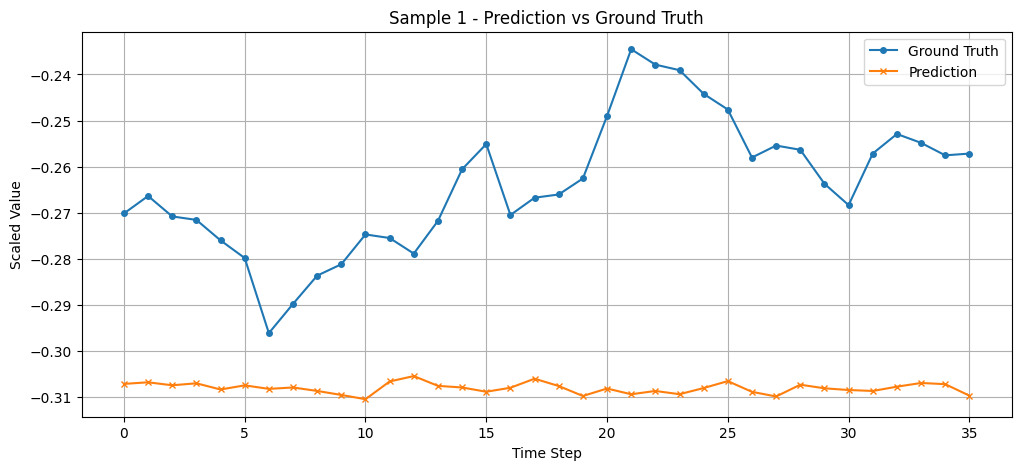

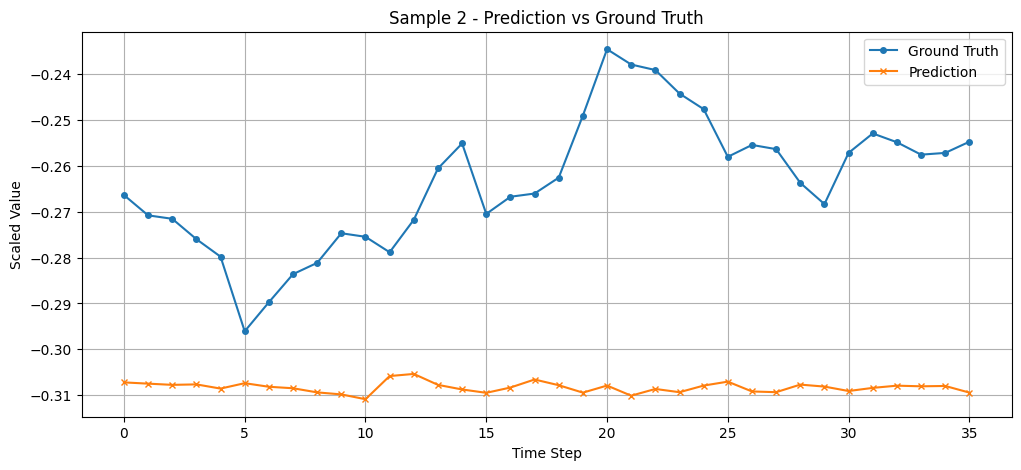

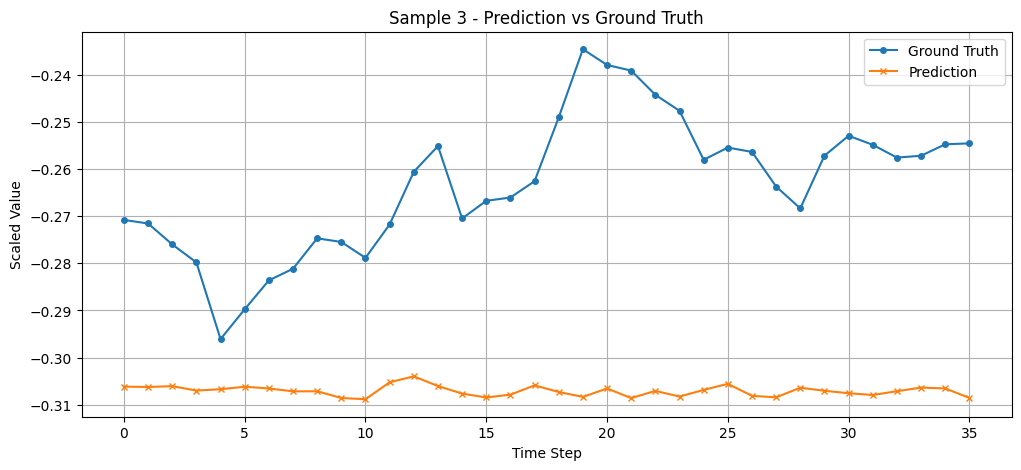

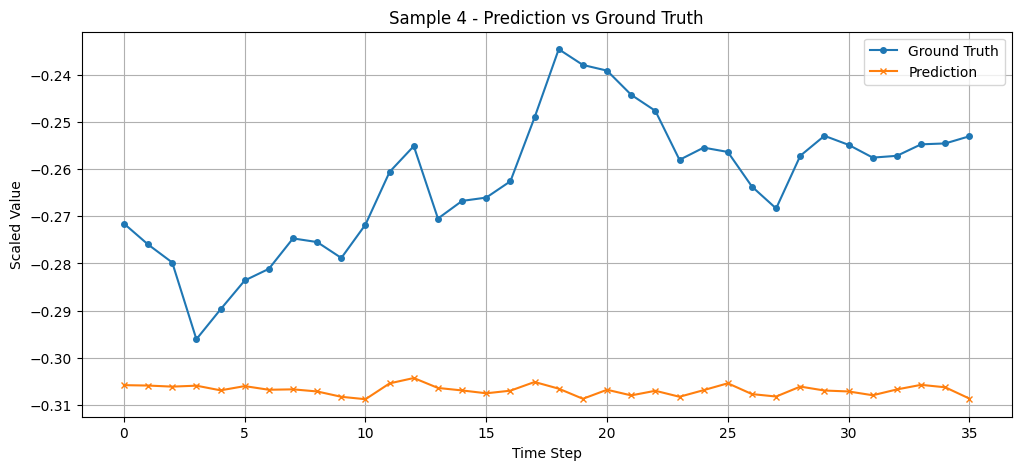

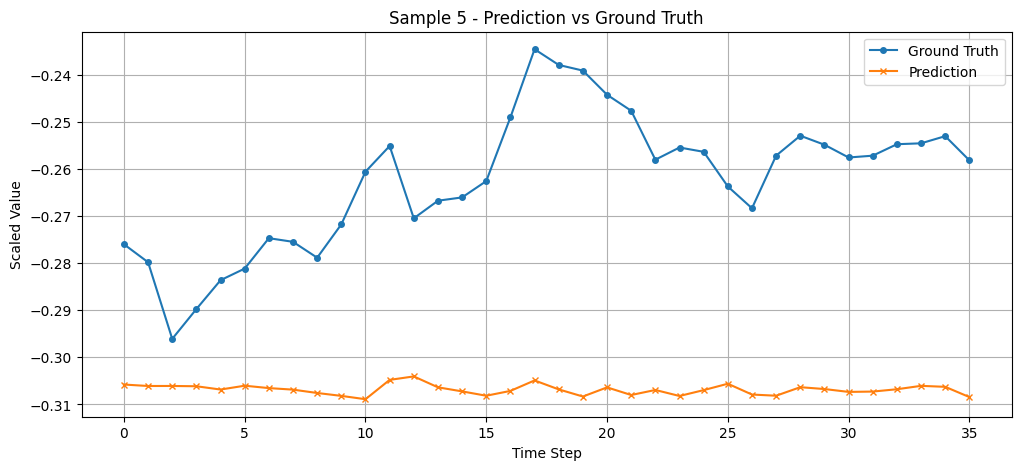

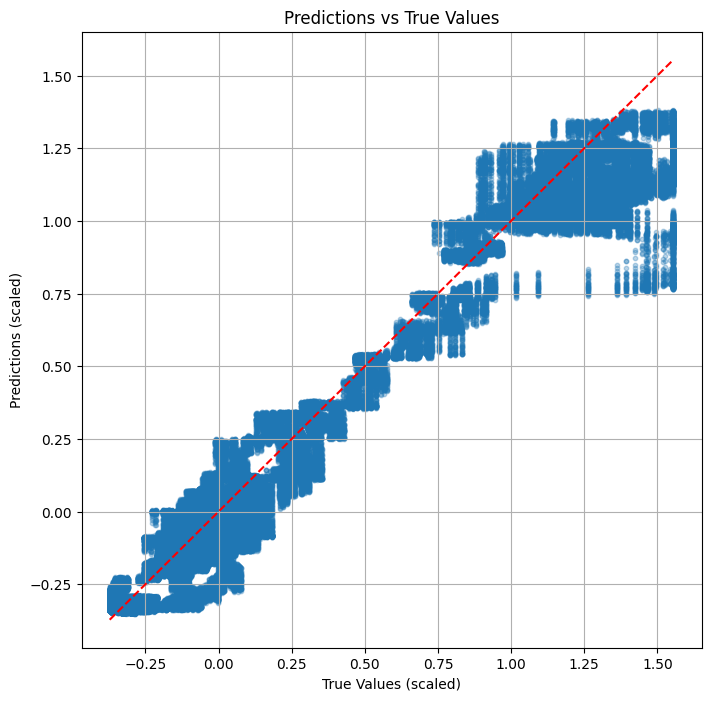

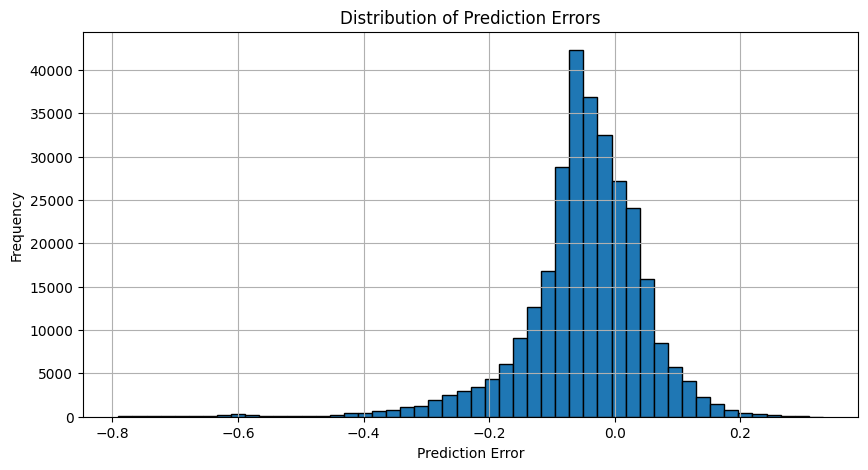

In [5]:
import sys
sys.path.append('/kaggle/working/RWKV-TS/src')  

import torch
import yaml
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from cnn_lstm_model import CNNLSTMModel 
from data_loader import CryptoDataset, CryptoDataLoader
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score,
    mean_absolute_percentage_error,
    median_absolute_error,
)

# 1. Load config từ file YAML
config_path = "/kaggle/working/RWKV-TS/configs/train_config.yaml"
with open(config_path) as f:
    config = yaml.safe_load(f)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2. Khởi tạo model 
model = CNNLSTMModel(config).to(device)  

# 3. Load weights từ best_model.pt
checkpoint_path = "/kaggle/input/cnn-lstm-model-training-using-swa/RWKV-TS/checkpoints/20250518_025056/best_epoch_7.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

# 4. Tạo tập train để lấy scalers (không dùng để train)
train_data_loader = CryptoDataLoader(config_path=config_path)
scalers = train_data_loader.scalers  # Lấy scalers đã được fit từ tập train

# 6. Tạo dataset test mới với class tùy chỉnh và scalers từ tập train
test_dataset = CryptoDataset(
    data_path="/kaggle/working/BNB_OHLC_5m.csv",
    config=config,
    train=False,
    scalers=scalers, 
    test_mode=True
)

# 7. Tạo DataLoader cho test
test_loader = DataLoader(
    test_dataset,
    batch_size=config['training']['batch_size'],
    shuffle=False,
    num_workers=4
)

# 8. Hàm dự đoán
def predict(model, data_loader):
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in data_loader:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            pred = model(x)
            predictions.append(pred.cpu().numpy())
            actuals.append(y.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(actuals)

# 9. Thực hiện dự đoán
preds, true_values = predict(model, test_loader)
print("Predictions shape:", preds.shape)

# 10. Đánh giá
y_true = true_values.flatten()
y_pred = preds.flatten()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
medae = median_absolute_error(y_true, y_pred)

# In kết quả
print("\nEvaluation Metrics:")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAPE  : {mape*100:.2f}%")
print(f"R²    : {r2:.4f}")
print(f"MedAE : {medae:.4f}")

# 11. Visualization
import matplotlib.pyplot as plt

# Vẽ biểu đồ cho 5 mẫu đầu tiên
num_plot = 5  
for i in range(num_plot):
    plt.figure(figsize=(12, 5))
    plt.plot(true_values[i], label="Ground Truth", marker='o', markersize=4)
    plt.plot(preds[i], label="Prediction", marker='x', markersize=4)
    plt.title(f"Sample {i+1} - Prediction vs Ground Truth")
    plt.xlabel("Time Step")
    plt.ylabel("Scaled Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.3, s=10)
plt.xlabel("True Values (scaled)")
plt.ylabel("Predictions (scaled)")
plt.title("Predictions vs True Values")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.grid(True)
plt.show()

# Phân phối lỗi
residuals = y_pred - y_true
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

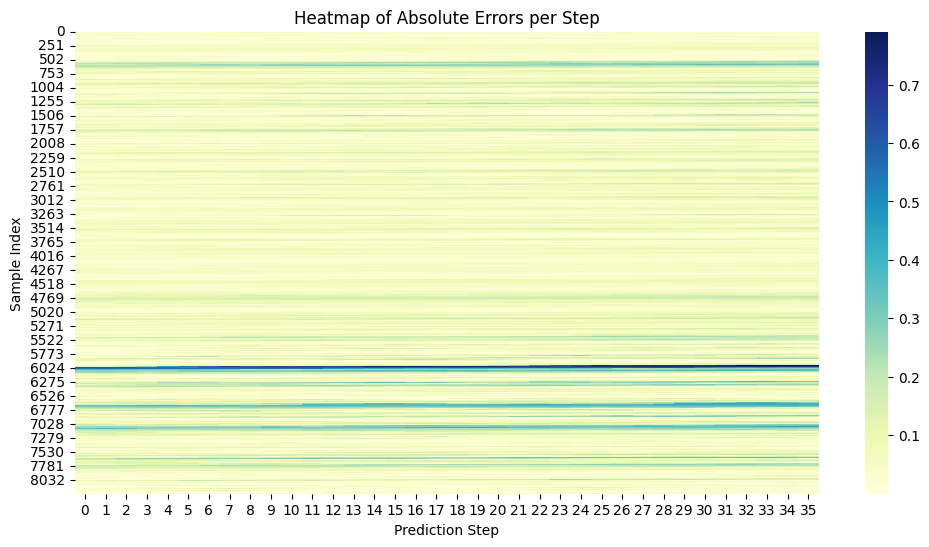

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

error_matrix = np.abs(preds - true_values).squeeze()  # (155008, 12, 1) -> (155008, 12)

# Hoặc: error_matrix = np.abs(preds.squeeze(-1) - true_values.squeeze(-1))

plt.figure(figsize=(12, 6))
sns.heatmap(error_matrix, cmap="YlGnBu", cbar=True)
plt.title("Heatmap of Absolute Errors per Step")
plt.xlabel("Prediction Step")
plt.ylabel("Sample Index")
plt.show()

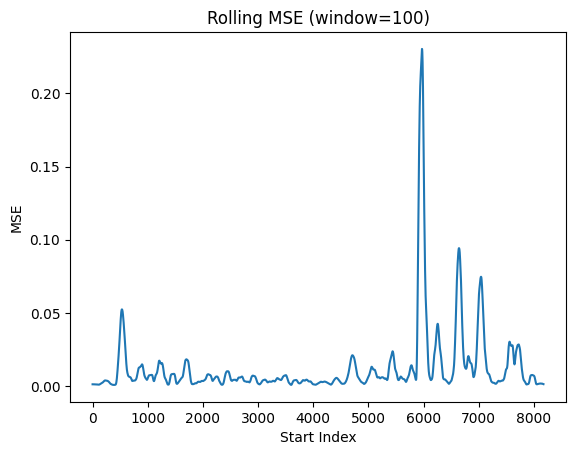

In [7]:
from sklearn.metrics import mean_squared_error

true_values_2d = true_values.squeeze(-1)
preds_2d = preds.squeeze(-1)

window_size = 100
rolling_mse = [
    mean_squared_error(true_values_2d[i:i+window_size], preds_2d[i:i+window_size])
    for i in range(len(true_values_2d) - window_size)
]

import matplotlib.pyplot as plt

plt.plot(rolling_mse)
plt.title("Rolling MSE (window=100)")
plt.xlabel("Start Index")
plt.ylabel("MSE")
plt.show()

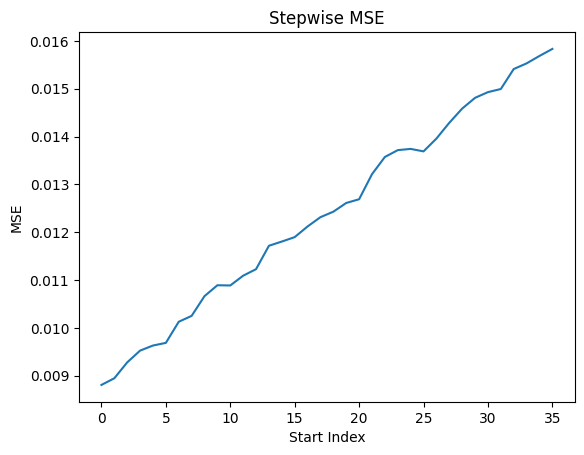

Steps to improve: [33 32 35]
Step 33: Median error = 0.064808
Step 32: Median error = 0.065111
Step 35: Median error = 0.066043


In [8]:
from sklearn.metrics import mean_squared_error

true_values_2d = true_values.squeeze(-1)
preds_2d = preds.squeeze(-1)

stepwise_mse = [
    mean_squared_error(true_values_2d[:, step], preds_2d[:, step])
    for step in range(true_values_2d.shape[1])
]

import matplotlib.pyplot as plt

plt.plot(stepwise_mse)
plt.title("Stepwise MSE")
plt.xlabel("Start Index")
plt.ylabel("MSE")
plt.show()

step_errors = np.median(error_matrix, axis=0)

worst_steps = np.argsort(step_errors)[-3:]

print(f"Steps to improve: {worst_steps}")
for step in worst_steps:
    print(f"Step {step}: Median error = {step_errors[step]:.6f}")